In [150]:
# %% --- Bloque 1: Importaciones ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import joblib  # Para guardar/cargar objetos Python (scalers)
import os  # Para interactuar con el sistema operativo (crear carpetas)
from datetime import timedelta  # Para cálculos de fechas (ajuste a lunes)

In [151]:
# %% --- Bloque 2: Carga, Verificación y Preparación de Datos ---

# Leer el CSV desde una carpeta anterior
# Asegúrate de que la ruta sea correcta
try:
    df = pd.read_csv("../data/df_demanda.csv", parse_dates=["Datetime"])
except FileNotFoundError:
    raise FileNotFoundError("Error: No se encontró el archivo '../data/df_demanda.csv'. Verifica la ruta.")

df.set_index("Datetime", inplace=True)
df = df.sort_index()

print("\n--- Verificaciones Esenciales ---")
if not isinstance(df.index, pd.DatetimeIndex):
    print("Advertencia: El índice no es DatetimeIndex. Intentando convertir...")
    try:
        df.index = pd.to_datetime(df.index)
        print("Índice convertido a Datetime con éxito.")
    except Exception as e:
        raise TypeError(f"No se pudo convertir el índice a Datetime. Verifica el formato. Error: {e}")
else:
    print("El índice ya es de tipo DatetimeIndex.")

required_cols = ['Mes', 'Hour', 'Season', 'Dia_habil', 'kWh']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Faltan columnas requeridas en el DataFrame: {missing_cols}")
else:
    print(f"Columnas requeridas ({required_cols}) encontradas.")

# Seleccionar solo las columnas necesarias y en orden
# Usar .copy() para evitar SettingWithCopyWarning más tarde
df = df[required_cols].copy()
print("DataFrame filtrado y copiado para mantener solo las columnas requeridas.")

print("\nÚltimas 5 filas del DataFrame 'df':")
print(df.tail())
print("\nInformación general del DataFrame 'df':")
df.info()



--- Verificaciones Esenciales ---
El índice ya es de tipo DatetimeIndex.
Columnas requeridas (['Mes', 'Hour', 'Season', 'Dia_habil', 'kWh']) encontradas.
DataFrame filtrado y copiado para mantener solo las columnas requeridas.

Últimas 5 filas del DataFrame 'df':
                     Mes  Hour  Season  Dia_habil      kWh
Datetime                                                  
2025-04-14 19:00:00    4    19       2          1  2003095
2025-04-14 20:00:00    4    20       2          1  1995673
2025-04-14 21:00:00    4    21       2          1  1946604
2025-04-14 22:00:00    4    22       2          1  1776689
2025-04-14 23:00:00    4    23       2          1  1602295

Información general del DataFrame 'df':
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133920 entries, 2010-01-04 00:00:00 to 2025-04-14 23:00:00
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Mes        133920 non-null  int64
 1   Hour       1339

### MODELO LSTM!

In [152]:
# %% --- Bloque 3: Ajuste de Inicio y Verificación de Longitud ---

print("\nAjustando el inicio del DataFrame al primer lunes a las 00:00...")

# Asegurar que el índice esté ordenado antes de buscar el primer día
if not df.index.is_monotonic_increasing:
     print("Advertencia: El índice no estaba ordenado. Ordenando...")
     df = df.sort_index()

if df.empty:
     raise ValueError("El DataFrame está vacío antes del ajuste de fecha.")

first_day_of_week = df.index[0].dayofweek
if first_day_of_week != 0:  # 0 es Lunes
    days_to_monday = (7 - first_day_of_week) % 7
    # Asegurarse de no sumar 0 días si ya es lunes
    if days_to_monday == 0:
         first_monday_date = df.index[0].normalize()
    else:
         first_monday_date = df.index[0].normalize() + timedelta(days=days_to_monday)

    print(f"Primer día detectado: {df.index[0].strftime('%Y-%m-%d %A')}")
    print(f"Se ajustará para empezar en: {first_monday_date.strftime('%Y-%m-%d %A')} 00:00")
    original_len = len(df)
    # Filtrar para incluir datos desde las 00:00 del primer lunes
    df = df.loc[first_monday_date:]
    print(f"Longitud antes del filtro: {original_len}, después: {len(df)}")
    if df.empty:
        raise ValueError("El DataFrame quedó vacío después del ajuste al primer lunes.")
    print(f"DataFrame ajustado. Nuevo inicio: {df.index.min()}")
else:
    print(f"El DataFrame ya comenzaba en Lunes ({df.index.min().strftime('%Y-%m-%d %A')}). No se requiere ajuste.")


Ajustando el inicio del DataFrame al primer lunes a las 00:00...
El DataFrame ya comenzaba en Lunes (2010-01-04 Monday). No se requiere ajuste.


In [153]:
# %% --- Bloque 4: Definición de Parámetros del Modelo y División de Datos ---

# Parámetros relacionados con las features y el target
N_FEATURES = df.shape[1]
try:
    # Índice de la columna objetivo ('kWh') dentro del DataFrame filtrado
    TARGET_FEATURE_INDEX = df.columns.get_loc('kWh')
except KeyError:
    raise KeyError("La columna 'kWh' no se encontró en el DataFrame después de la selección.")

# Paso (stride) para la ventana deslizante
STEP_WINDOW = 168  # Deslizar la ventana cada día

print("\n--- Parámetros Definidos ---")
print(f"Tamaño de ventana de entrada/salida: {WINDOW_SIZE_HOURS} horas ({WINDOW_SIZE_WEEKS} semanas)")
print(f"Número de características (features): {N_FEATURES}")
print(f"Índice de la característica objetivo ('kWh'): {TARGET_FEATURE_INDEX}")
print(f"Paso de la ventana deslizante: {STEP_WINDOW} horas")

# --- División Temporal: Train / Validation / Test ---
print("\nDividiendo los datos en conjuntos de Entrenamiento, Validación y Prueba...")
total_hours = len(df)
train_split_idx = int(total_hours * 0.70)
val_split_idx = int(total_hours * 0.90)  # 70% train + 20% val = 90%

train_df = df.iloc[:train_split_idx].copy()
val_df = df.iloc[train_split_idx:val_split_idx].copy()
test_df = df.iloc[val_split_idx:].copy()

# Guardar el índice original del conjunto de prueba para graficar más tarde
test_dates_original = test_df.index

# Comprobar si CADA conjunto tiene suficientes datos para generar al menos UNA ventana completa
def check_min_length_for_windows(df_split, name, window_size, step):
    n_total_steps = len(df_split)
    # Se necesitan datos para una ventana de entrada Y una de salida
    required_length = 2 * window_size
    if n_total_steps < required_length:
        print(f"¡Advertencia! El conjunto '{name}' ({n_total_steps} horas) "
              f"es demasiado corto para generar al menos una secuencia de entrada/salida "
              f"({required_length} horas requeridas).")
        return False
    # Adicionalmente, verificar cuántas ventanas se pueden generar con el step
    num_windows = (n_total_steps - required_length) // step + 1
    print(f"Conjunto '{name}' ({n_total_steps} horas) puede generar {num_windows} ventana(s).")
    if num_windows == 0:
         print(f"¡Advertencia! El conjunto '{name}' no puede generar ni una ventana completa con step={step}.")
         return False
    return True


print("\n--- Verificación de Longitud Mínima Post-División ---")
is_train_ok = check_min_length_for_windows(train_df, "Train", WINDOW_SIZE_HOURS, STEP_WINDOW)
is_val_ok = check_min_length_for_windows(val_df, "Validation", WINDOW_SIZE_HOURS, STEP_WINDOW)
is_test_ok = check_min_length_for_windows(test_df, "Test", WINDOW_SIZE_HOURS, STEP_WINDOW)

if not is_test_ok:
    raise ValueError(f"El conjunto de Test es demasiado corto ({len(test_df)}) para generar "
                     f"incluso una ventana de entrada/salida ({2 * WINDOW_SIZE_HOURS}). "
                     "Ajusta los porcentajes de división o el tamaño de la ventana.")
if not is_train_ok or not is_val_ok:
    print("Advertencia: Los conjuntos de Train o Validación son muy cortos. "
          "El modelo podría no entrenar o validar correctamente.")


print("\n--- Tamaños de los Conjuntos ---")
print(f"Entrenamiento (Train): {len(train_df)} horas ({train_df.index.min()} a {train_df.index.max()})")
print(f"Validación (Val):    {len(val_df)} horas ({val_df.index.min()} a {val_df.index.max()})")
print(f"Prueba (Test):       {len(test_df)} horas ({test_df.index.min()} a {test_df.index.max()})")


--- Parámetros Definidos ---
Tamaño de ventana de entrada/salida: 336 horas (2 semanas)
Número de características (features): 5
Índice de la característica objetivo ('kWh'): 4
Paso de la ventana deslizante: 168 horas

Dividiendo los datos en conjuntos de Entrenamiento, Validación y Prueba...

--- Verificación de Longitud Mínima Post-División ---
Conjunto 'Train' (93744 horas) puede generar 555 ventana(s).
Conjunto 'Validation' (26784 horas) puede generar 156 ventana(s).
Conjunto 'Test' (13392 horas) puede generar 76 ventana(s).

--- Tamaños de los Conjuntos ---
Entrenamiento (Train): 93744 horas (2010-01-04 00:00:00 a 2020-09-13 23:00:00)
Validación (Val):    26784 horas (2020-09-14 00:00:00 a 2023-10-04 23:00:00)
Prueba (Test):       13392 horas (2023-10-05 00:00:00 a 2025-04-14 23:00:00)


In [154]:
# %% --- Bloque 5: Escalado de Características y Guardado de Scalers ---

print("\nEscalando características (MinMaxScaler) y guardando scalers...")

# Crear carpeta para guardar los scalers si no existe
scaler_folder = "scalers"
os.makedirs(scaler_folder, exist_ok=True)
feature_scaler_path = os.path.join(scaler_folder, "feature_scaler.joblib")
target_scaler_path = os.path.join(scaler_folder, "target_scaler.joblib")

# 1. Scaler para TODAS las características (Entrada X)
#    Se ajusta SOLO con datos de entrenamiento para evitar fuga de datos.
feature_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler.fit(train_df)
# Se aplica a todos los conjuntos
train_scaled_features = feature_scaler.transform(train_df)
val_scaled_features = feature_scaler.transform(val_df)
test_scaled_features = feature_scaler.transform(test_df)
joblib.dump(feature_scaler, feature_scaler_path)
print(f" - Feature scaler (para todas las features) ajustado y guardado en: {feature_scaler_path}")

# 2. Scaler específico para la característica OBJETIVO ('kWh')
#    Se usará únicamente para DESESCALAR las predicciones y los valores reales de 'kWh'.
#    Se ajusta SOLO con la columna 'kWh' de entrenamiento.
target_scaler = MinMaxScaler(feature_range=(0, 1))
# Asegurarse de que sea un DataFrame 2D lo que se pasa a fit
target_scaler.fit(train_df[['kWh']])
joblib.dump(target_scaler, target_scaler_path)
print(f" - Target scaler (solo para 'kWh') ajustado y guardado en: {target_scaler_path}")

# Nota: Los datos escalados son arrays de NumPy
print(f"\nForma de train_scaled_features: {train_scaled_features.shape}")
print(f"Forma de val_scaled_features: {val_scaled_features.shape}")
print(f"Forma de test_scaled_features: {test_scaled_features.shape}")



Escalando características (MinMaxScaler) y guardando scalers...
 - Feature scaler (para todas las features) ajustado y guardado en: scalers/feature_scaler.joblib
 - Target scaler (solo para 'kWh') ajustado y guardado en: scalers/target_scaler.joblib

Forma de train_scaled_features: (93744, 5)
Forma de val_scaled_features: (26784, 5)
Forma de test_scaled_features: (13392, 5)


In [155]:
# %% --- Bloque 6: Función para Crear Ventanas Deslizantes (CORREGIDA) ---

def create_windows(data_scaled, target_col_index, window_size, step):
    """
    Genera pares de secuencias de entrada (X) y salida (y) usando una ventana deslizante
    a partir de datos YA ESCALADOS.
    La salida 'y' contendrá únicamente la columna objetivo (ya escalada).
    """
    X, y = [], []
    n_total_records = len(data_scaled)
    # Longitud total necesaria para una muestra (entrada + salida)
    required_length = 2 * window_size

    if n_total_records < required_length:
         print(f"Advertencia en create_windows: Los datos proporcionados ({n_total_records} registros) "
               f"son insuficientes para crear una ventana de entrada/salida de tamaño {window_size}*2.")
         return np.array(X), np.array(y) # Devolver arrays vacíos con forma correcta si es posible

    # Iterar asegurando espacio para ventana de entrada y ventana de salida consecutiva
    for i in range(0, n_total_records - required_length + 1, step):
        input_start = i
        input_end = i + window_size
        output_start = i + window_size
        output_end = i + 2 * window_size # = output_start + window_size

        # Ventana de Entrada (X): Todas las características, ya escaladas
        X_window = data_scaled[input_start:input_end, :]
        X.append(X_window)

        # Ventana de Salida (y): SOLO la columna objetivo, ya escalada
        # Extraemos la columna objetivo del tramo de datos correspondiente a la salida
        y_window_target_col = data_scaled[output_start:output_end, target_col_index]
        # Aseguramos que tenga la forma (window_size, 1) para la LSTM
        y.append(y_window_target_col.reshape(-1, 1))

    X = np.array(X)
    y = np.array(y)

    if X.shape[0] == 0 or y.shape[0] == 0:
        print(f"Advertencia: No se generaron ventanas (data len: {n_total_records}, "
              f"window: {window_size}, step: {step}). Verifica la longitud de los datos de entrada.")

    return X, y

print("Función 'create_windows' (CORREGIDA) definida.")
print(" - Ya NO re-escala 'y' dentro de la función.")
print(" - Espera que 'data_scaled' ya esté escalado correctamente.")

Función 'create_windows' (CORREGIDA) definida.
 - Ya NO re-escala 'y' dentro de la función.
 - Espera que 'data_scaled' ya esté escalado correctamente.


In [156]:
# %% --- Bloque 7: Generación de Ventanas para Train/Val/Test (Usando función corregida) ---

print("\nGenerando ventanas para los conjuntos de train, val y test...")

# Llamar a la función CORREGIDA (sin pasar target_scaler)
X_train, y_train = create_windows(train_scaled_features, TARGET_FEATURE_INDEX, WINDOW_SIZE_HOURS, step=STEP_WINDOW)
X_val, y_val = create_windows(val_scaled_features, TARGET_FEATURE_INDEX, WINDOW_SIZE_HOURS, step=STEP_WINDOW)
X_test, y_test = create_windows(test_scaled_features, TARGET_FEATURE_INDEX, WINDOW_SIZE_HOURS, step=STEP_WINDOW)

# Verificar que se hayan generado ventanas
if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
    raise ValueError("No se pudieron generar ventanas para uno o más conjuntos (train/val/test). "
                     f"Verifica las longitudes de los DataFrames divididos ({len(train_df)}, {len(val_df)}, {len(test_df)}) "
                     f"en relación al tamaño de ventana ({WINDOW_SIZE_HOURS}) y paso ({STEP_WINDOW}).")

print("\n--- Formas Finales de los Tensores ---")
print("Formato: (Muestras, Pasos de Tiempo, Características)")
print(f"X_train shape: {X_train.shape}") # (num_samples, window_size, n_features)
print(f"y_train shape: {y_train.shape}") # (num_samples, window_size, 1) <-- Solo la feature target
print(f"X_val shape:   {X_val.shape}")
print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}") # (num_test_samples, window_size, 1)


Generando ventanas para los conjuntos de train, val y test...

--- Formas Finales de los Tensores ---
Formato: (Muestras, Pasos de Tiempo, Características)
X_train shape: (555, 336, 5)
y_train shape: (555, 336, 1)
X_val shape:   (156, 336, 5)
y_val shape:   (156, 336, 1)
X_test shape:  (76, 336, 5)
y_test shape:  (76, 336, 1)


In [157]:
# %% --- Bloque 8: Construcción del Modelo LSTM Seq2Seq ---

print("\nConstruyendo la arquitectura del modelo LSTM...")

def build_lstm_model(input_shape_model, output_steps_model):
    """Define la arquitectura de la red neuronal LSTM Seq2Seq."""
    model = keras.Sequential(name="LSTM_Seq2Seq_Demanda")
    # Capa LSTM 1: necesita input_shape, devuelve secuencia completa para la siguiente LSTM
    model.add(layers.LSTM(units=100, return_sequences=True, input_shape=input_shape_model, name="LSTM_1"))
    # (Opcional) Dropout para regularización
    # model.add(layers.Dropout(0.2, name="Dropout_1"))
    # Capa LSTM 2: devuelve secuencia completa para la capa TimeDistributed
    model.add(layers.LSTM(units=80, return_sequences=True, name="LSTM_2"))
    # (Opcional) Dropout
    # model.add(layers.Dropout(0.2, name="Dropout_2"))
    # Capa de Salida: TimeDistributed aplica una capa Dense a CADA paso de tiempo de la secuencia de salida de la LSTM.
    # units=1 porque queremos predecir un solo valor (kWh) en cada paso de tiempo futuro.
    # activation='linear' es común para regresión, pero 'relu' podría probarse si los valores son siempre >= 0.
    model.add(layers.TimeDistributed(layers.Dense(units=1, activation='linear'), name="Output_kWh"))
    return model

# Definir la forma de entrada y crear el modelo
# input_shape = (timesteps, features) = (WINDOW_SIZE_HOURS, N_FEATURES)
input_shape = (WINDOW_SIZE_HOURS, N_FEATURES)
model = build_lstm_model(input_shape, WINDOW_SIZE_HOURS) # output_steps_model no se usa en esta definición, pero se mantiene por si acaso

print("\n--- Resumen del Modelo ---")
model.summary()


Construyendo la arquitectura del modelo LSTM...

--- Resumen del Modelo ---


/home/duck-analytics/proyectos/reac_and_fastapi/entorno_jupyter/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Seq2Seq_Demanda"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 336, 100)       │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 336, 80)        │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_kWh (TimeDistributed)    │ (None, 336, 1)         │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,401 (392.19 KB)

 Trainable params: 100,401 (392.19 KB)

 Non-trainable params: 0 (0.00 B)

In [158]:
# %% --- Bloque 9: Compilación del Modelo ---

print("\nCompilando el modelo...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Adam con learning rate explícito (ajustable)
    loss='mse',      # Mean Squared Error: sensible a outliers
    # loss='mae',      # Mean Absolute Error: más robusto a outliers
    metrics=['mae']  # Métrica fácil de interpretar
)
print("Modelo compilado con optimizador 'Adam', pérdida 'mse' y métrica 'mae'.")


Compilando el modelo...
Modelo compilado con optimizador 'Adam', pérdida 'mse' y métrica 'mae'.


In [159]:
# %% --- Bloque 10: Entrenamiento del Modelo ---

print("\nIniciando el entrenamiento del modelo...")

# Callbacks para mejorar el entrenamiento
callbacks = [
    # Detener si la pérdida de validación no mejora en 'patience' épocas
    # restore_best_weights=True guarda el modelo de la mejor época
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    # Reducir tasa de aprendizaje si la pérdida de validación se estanca
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
    # (Opcional) Guardar el mejor modelo en un archivo
    # keras.callbacks.ModelCheckpoint('mejor_modelo_entrenamiento.keras', save_best_only=True, monitor='val_loss')
]

# --- AJUSTE DE HIPERPARÁMETROS ---
EPOCHS = 50 # Aumentar épocas, EarlyStopping decidirá cuándo parar
BATCH_SIZE = 32  # Tamaño del lote (ajustar según memoria y velocidad de convergencia)

# Ejecutar el entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), # Usar datos de validación para monitorear overfitting
    callbacks=callbacks,            # Aplicar callbacks definidos
    verbose=1                       # Mostrar progreso (1: barra, 2: línea por época, 0: silencioso)
)

# Informar cuántas épocas realmente se ejecutaron
num_epochs_run = len(history.history['loss'])
print(f"\nEntrenamiento completado. Se ejecutaron {num_epochs_run} épocas.")


Iniciando el entrenamiento del modelo...
Epoch 1/50


18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 682ms/step - loss: 0.1394 - mae: 0.3005 - val_loss: 0.0458 - val_mae: 0.1827 - learning_rate: 0.0010
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - loss: 0.0341 - mae: 0.1512 - val_loss: 0.0402 - val_mae: 0.1692 - learning_rate: 0.0010
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 480ms/step - loss: 0.0247 - mae: 0.1307 - val_loss: 0.0207 - val_mae: 0.1202 - learning_rate: 0.0010
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 483ms/step - loss: 0.0153 - mae: 0.1007 - val_loss: 0.0090 - val_mae: 0.0704 - learning_rate: 0.0010
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - loss: 0.0100 - mae: 0.0780 - val_loss: 0.0123 - val_mae: 0.0885 - learning_rate: 0.0010
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step - loss: 0.0094 - mae: 0.0747 - val_loss: 0.0098 - val_mae: 0.0777 - learning_rate: 0.0010
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 485ms/step - loss: 0.0087 - mae: 0.0716 - val_loss: 0.0085 - val_mae: 0.0698 - learning_rate: 0.0010
Epoch 8/50
18/18

In [166]:
# %% --- Bloque 11: Evaluación Final en Conjunto de Prueba ---

print("\nEvaluando el rendimiento final en el conjunto de prueba...")

# 1. Evaluar con datos escalados (loss y métricas escaladas)
#    Esto refleja cómo el modelo "ve" el error internamente.
test_loss_scaled, test_mae_scaled = model.evaluate(X_test, y_test, verbose=0)
print(f"  - Loss (MSE) en prueba (escalado): {test_loss_scaled:.6f}")
print(f"  - MAE en prueba (escalado):        {test_mae_scaled:.6f}")

# 2. Hacer predicciones (saldrán escaladas, con forma [n_samples, window_size, 1])
y_pred_scaled = model.predict(X_test)
print(f"  - Forma de las predicciones escaladas (y_pred_scaled): {y_pred_scaled.shape}")
print(f"  - Forma de los valores reales escalados (y_test): {y_test.shape}")

# 3. Desescalar predicciones y valores reales usando el target_scaler (ajustado solo en 'kWh')
#    Esto es CRUCIAL para interpretar los resultados en las unidades originales (kWh).

# Asegurarse de que y_test y y_pred_scaled tengan la forma correcta para inverse_transform
# Se necesita una forma 2D: (total_samples * timesteps, 1 feature)
pred_samples, pred_timesteps, pred_features = y_pred_scaled.shape
test_samples, test_timesteps, test_features = y_test.shape

# Reshape a 2D -> inverse_transform -> reshape de nuevo a 3D original
y_pred_unscaled = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(pred_samples, pred_timesteps, pred_features)
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(test_samples, test_timesteps, test_features)

print("  - Predicciones (y_pred_unscaled) y valores reales (y_test_unscaled) desescalados.")
print(f"  - Forma de y_pred_unscaled: {y_pred_unscaled.shape}")
print(f"  - Forma de y_test_unscaled: {y_test_unscaled.shape}")


# 4. Calcular métricas con valores DESESCALADOS (en unidades originales, kWh)
#    Usar .flatten() para comparar todos los puntos predichos vs reales directamente.
mae_unscaled = mean_absolute_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten())
rmse_unscaled = np.sqrt(mean_squared_error(y_test_unscaled.flatten(), y_pred_unscaled.flatten()))

print(f"\n--- Métricas en Conjunto de Prueba (DESESCALADO, en kWh) ---")
print(f"  - MAE : {mae_unscaled:.3f} kWh")
print(f"  - RMSE: {rmse_unscaled:.3f} kWh")

# Calcular un MAE promedio por paso de tiempo (opcional, puede dar idea de degradación)
# mae_per_step = np.mean(np.abs(y_pred_unscaled - y_test_unscaled), axis=(0, 2)) # Promedio sobre muestras y feature=1
# print(f"  - MAE promedio por paso de tiempo (primeros 5): {mae_per_step[:5]}")


Evaluando el rendimiento final en el conjunto de prueba...
  - Loss (MSE) en prueba (escalado): 0.010622
  - MAE en prueba (escalado):        0.072922
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
  - Forma de las predicciones escaladas (y_pred_scaled): (76, 336, 1)
  - Forma de los valores reales escalados (y_test): (76, 336, 1)
  - Predicciones (y_pred_unscaled) y valores reales (y_test_unscaled) desescalados.
  - Forma de y_pred_unscaled: (76, 336, 1)
  - Forma de y_test_unscaled: (76, 336, 1)

--- Métricas en Conjunto de Prueba (DESESCALADO, en kWh) ---
  - MAE : 471852.280 kWh
  - RMSE: 666871.099 kWh



Generando gráfica de Predicción vs Real en Test (con eje temporal)...
Mostrando gráfica para la ventana de prueba aleatoria índice: 33
  Rango de valores REALES (kWh) para muestra 33: min=6728595.00, max=10804804.00
  Rango de valores PREDICHOS (kWh) para muestra 33: min=4737589.00, max=10578688.00


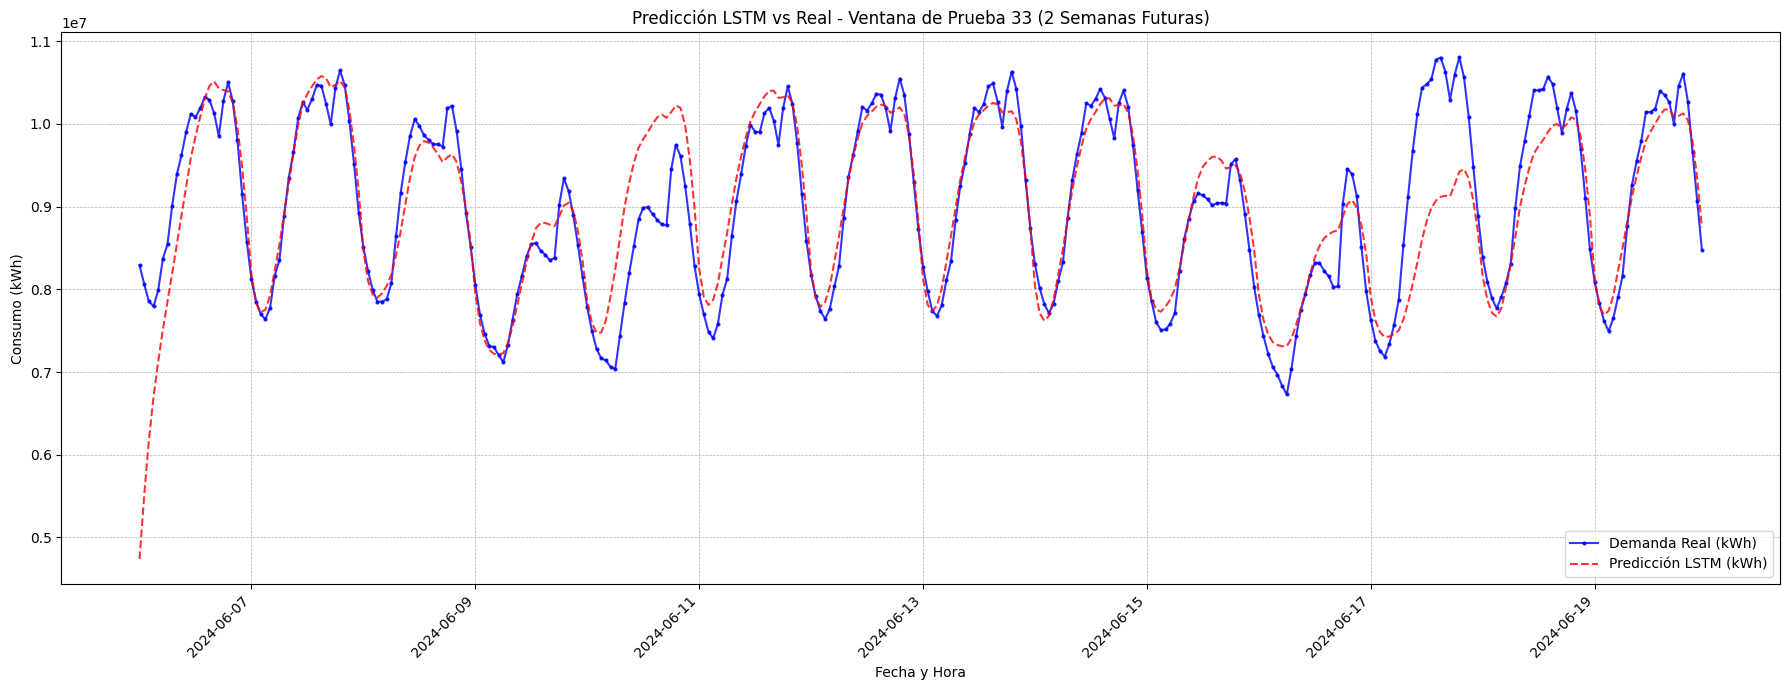

In [168]:
# %% --- Bloque 12: Visualización - Predicción vs Real (CONSOLIDADO) ---

print("\nGenerando gráfica de Predicción vs Real en Test (con eje temporal)...")

# Asegurarse de que y_pred_unscaled exista y tenga muestras
if 'y_pred_unscaled' in locals() and y_pred_unscaled.shape[0] > 0:

    # --- Elegir qué ventana de prueba visualizar ---
    # sample_index_to_plot = 0 # Siempre la primera ventana generada
    # O elegir una aleatoria:
    max_index = y_pred_unscaled.shape[0] - 1
    sample_index_to_plot = np.random.randint(0, max_index + 1) if max_index >= 0 else 0
    print(f"Mostrando gráfica para la ventana de prueba aleatoria índice: {sample_index_to_plot}")

    # Calcular el rango de índices en el DataFrame de prueba ORIGINAL (`test_df`)
    # que corresponde a la ventana de SALIDA (predicción) de esta muestra.
    # El índice inicial es: (índice_muestra * paso) + tamaño_ventana_entrada
    start_idx_in_test_df = sample_index_to_plot * STEP_WINDOW + WINDOW_SIZE_HOURS
    end_idx_in_test_df = start_idx_in_test_df + WINDOW_SIZE_HOURS

    # Verificar que los índices calculados estén dentro de los límites de test_df
    if end_idx_in_test_df <= len(test_df):
        # Obtener las fechas correspondientes del índice de test_df
        prediction_dates = test_df.index[start_idx_in_test_df : end_idx_in_test_df]

        # Obtener los valores REALES (originales, no escalados) de 'kWh' de test_df
        actual_values_for_plot = test_df['kWh'].iloc[start_idx_in_test_df : end_idx_in_test_df].values

        # Obtener las predicciones DESESCALADAS para esa ventana específica
        # Acceder a la muestra [sample_index_to_plot], todos los pasos de tiempo [:], y la única feature [0]
        predicted_values_for_plot = y_pred_unscaled[sample_index_to_plot, :, 0]

        # Asegurar coincidencia de longitudes (deberían coincidir si todo está bien)
        min_len = min(len(prediction_dates), len(actual_values_for_plot), len(predicted_values_for_plot))
        if len(prediction_dates) != min_len or len(actual_values_for_plot) != min_len or len(predicted_values_for_plot) != min_len:
             print(f"Advertencia: Discrepancia en longitudes al graficar muestra {sample_index_to_plot}. Recortando a {min_len}.")
             prediction_dates = prediction_dates[:min_len]
             actual_values_for_plot = actual_values_for_plot[:min_len]
             predicted_values_for_plot = predicted_values_for_plot[:min_len]

        # --- IMPRESIONES DE DEPURACIÓN (Útil para verificar rangos) ---
        print(f"  Rango de valores REALES (kWh) para muestra {sample_index_to_plot}: min={np.min(actual_values_for_plot):.2f}, max={np.max(actual_values_for_plot):.2f}")
        print(f"  Rango de valores PREDICHOS (kWh) para muestra {sample_index_to_plot}: min={np.min(predicted_values_for_plot):.2f}, max={np.max(predicted_values_for_plot):.2f}")
        # ---------------------------------

        # Crear gráfica
        plt.figure(figsize=(18, 7))
        plt.plot(prediction_dates, actual_values_for_plot, label='Demanda Real (kWh)', color='blue', linewidth=1.5, marker='.', markersize=4, alpha=0.8)
        plt.plot(prediction_dates, predicted_values_for_plot, label='Predicción LSTM (kWh)', color='red', linestyle='--', linewidth=1.5, alpha=0.8)
        plt.title(f'Predicción LSTM vs Real - Ventana de Prueba {sample_index_to_plot} ({WINDOW_SIZE_WEEKS} Semanas Futuras)')
        plt.xlabel('Fecha y Hora')
        plt.ylabel('Consumo (kWh)')
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.xticks(rotation=45, ha='right') # Rotar etiquetas eje X para mejor legibilidad
        plt.tight_layout() # Ajustar layout para evitar solapamiento
        plt.show()

    else:
        print(f"Error al graficar muestra {sample_index_to_plot}: "
              f"El índice final calculado ({end_idx_in_test_df}) excede la longitud de test_df ({len(test_df)}). "
              "Esto puede ocurrir si la última ventana generada está muy cerca del final de los datos.")

elif 'y_pred_unscaled' not in locals():
     print("Error: La variable 'y_pred_unscaled' no fue encontrada. Asegúrate de ejecutar el bloque de evaluación (Bloque 11) primero.")
elif y_pred_unscaled.shape[0] == 0:
     print("Error: No se generaron predicciones (y_pred_unscaled está vacío). Revisa los pasos anteriores.")
else:
    print("Condición inesperada al intentar graficar.")


Generando gráficas del historial de entrenamiento...


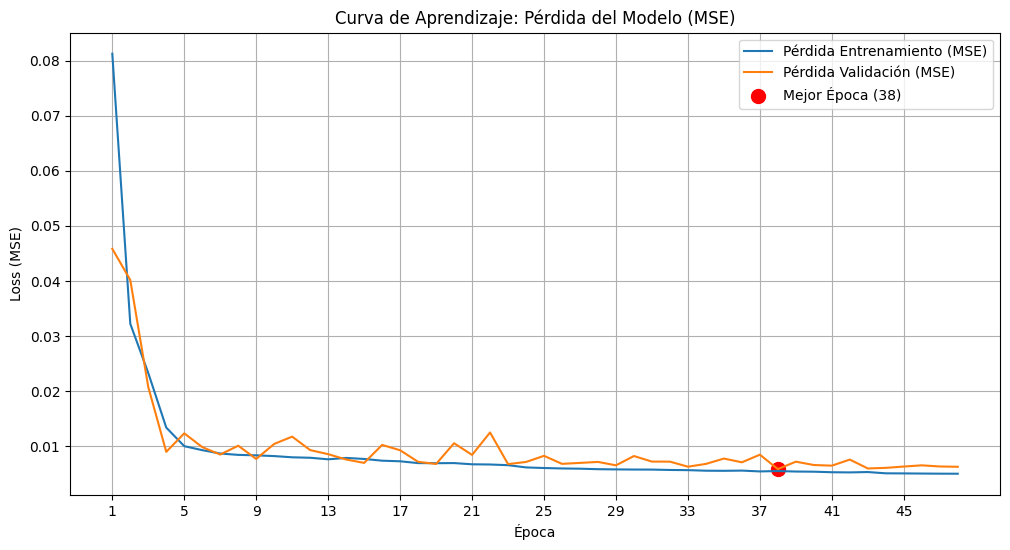

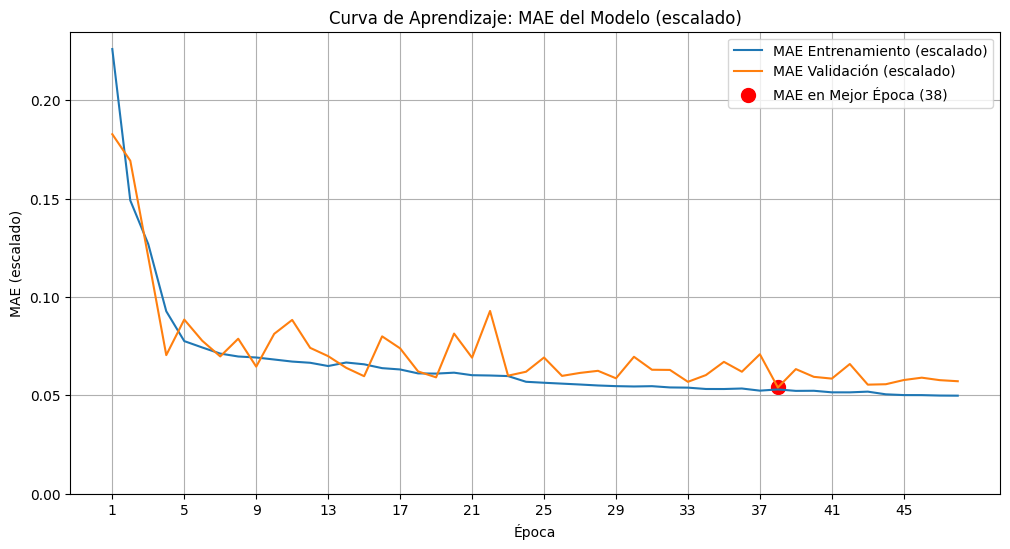


--- Proceso Completado ---


In [169]:
# %% --- Bloque 13: Visualización - Curvas de Aprendizaje (CONSOLIDADO) ---

print("\nGenerando gráficas del historial de entrenamiento...")

history_dict = history.history

# Verificar si el entrenamiento se ejecutó (history_dict no estará vacío)
if history_dict:
    epochs_range = range(1, num_epochs_run + 1) # Eje X para las gráficas

    # --- Gráfica de Pérdida (Loss) ---
    if 'loss' in history_dict and 'val_loss' in history_dict:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, history_dict['loss'], label='Pérdida Entrenamiento (MSE)')
        plt.plot(epochs_range, history_dict['val_loss'], label='Pérdida Validación (MSE)')
        # Marcar la mejor época (si EarlyStopping restauró pesos)
        best_epoch = np.argmin(history_dict['val_loss']) + 1
        plt.scatter(best_epoch, history_dict['val_loss'][best_epoch-1],
                    marker='o', color='red', s=100, label=f'Mejor Época ({best_epoch})')

        plt.title('Curva de Aprendizaje: Pérdida del Modelo (MSE)')
        plt.xlabel('Época')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(1, num_epochs_run + 1, step=max(1, num_epochs_run // 10))) # Mejorar ticks del eje X
        # plt.ylim(bottom=0) # Puede ser útil, pero a veces oculta detalles iniciales
        plt.show()
    else:
        print("Advertencia: No se encontró 'loss' o 'val_loss' en el historial. No se puede graficar la pérdida.")

    # --- Gráfica de MAE (si está disponible) ---
    if 'mae' in history_dict and 'val_mae' in history_dict:
        plt.figure(figsize=(12, 6))
        plt.plot(epochs_range, history_dict['mae'], label='MAE Entrenamiento (escalado)')
        plt.plot(epochs_range, history_dict['val_mae'], label='MAE Validación (escalado)')
        # Marcar MAE en la mejor época de *loss* (son métricas escaladas)
        plt.scatter(best_epoch, history_dict['val_mae'][best_epoch-1],
                    marker='o', color='red', s=100, label=f'MAE en Mejor Época ({best_epoch})')

        plt.title('Curva de Aprendizaje: MAE del Modelo (escalado)')
        plt.xlabel('Época')
        plt.ylabel('MAE (escalado)')
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(1, num_epochs_run + 1, step=max(1, num_epochs_run // 10)))
        plt.ylim(bottom=0) # MAE no puede ser negativo
        plt.show()
    else:
        print("Advertencia: No se encontró 'mae' o 'val_mae' en el historial. No se puede graficar MAE.")
else:
    print("El historial de entrenamiento está vacío. No se pueden generar las curvas de aprendizaje.")

print("\n--- Proceso Completado ---")


In [163]:

# %% --- Bloque 14: Guardar Modelo y Scalers para Despliegue ---

print("\nGuardando el modelo entrenado y los scalers...")

# Crear carpeta para el modelo si no existe
model_folder = "trained_model"
os.makedirs(model_folder, exist_ok=True)

# 1. Guardar el modelo Keras
model_path = os.path.join(model_folder, "lstm_demand_model.keras")
model.save(model_path)
print(f" - Modelo Keras guardado en: {model_path}")

# 2. Guardar los scalers (ya los guardaste en Bloque 5, pero asegúrate de que las rutas sean conocidas)
#    Las rutas usadas en Bloque 5 fueron:
#    feature_scaler_path = "scalers/feature_scaler.joblib"
#    target_scaler_path = "scalers/target_scaler.joblib"
#    Asegúrate de que estos archivos existen después de correr el script.
print(f" - Feature scaler guardado en: {feature_scaler_path}")
print(f" - Target scaler guardado en: {target_scaler_path}")

# 3. (Importante) Anota los parámetros clave necesarios para la predicción:
print("\n--- Parámetros Clave para Predicción ---")
print(f"WINDOW_SIZE_HOURS: {WINDOW_SIZE_HOURS}") # Debería ser 336
print(f"N_FEATURES: {N_FEATURES}")             # Debería ser 5
print(f"TARGET_FEATURE_INDEX: {TARGET_FEATURE_INDEX}") # Índice de 'kWh' (probablemente 4)
print(f"Required Columns (Order matters!): {required_cols}") # ['Mes', 'Hour', 'Season', 'Dia_habil', 'kWh']


Guardando el modelo entrenado y los scalers...
 - Modelo Keras guardado en: trained_model/lstm_demand_model.keras
 - Feature scaler guardado en: scalers/feature_scaler.joblib
 - Target scaler guardado en: scalers/target_scaler.joblib

--- Parámetros Clave para Predicción ---
WINDOW_SIZE_HOURS: 336
N_FEATURES: 5
TARGET_FEATURE_INDEX: 4
Required Columns (Order matters!): ['Mes', 'Hour', 'Season', 'Dia_habil', 'kWh']
